## package import

In [1]:

#import libraries
import cytoflow as flow

# mpl.use('TkAgg')
from itertools import product
import os
%matplotlib inline
import matplotlib as mpl
from matplotlib.ticker import FuncFormatter
import scipy
import seaborn as sns
import matplotlib.pyplot as plt
import math
import pandas as pd
import numpy as np
from scipy.optimize import curve_fit
import sklearn
import sys
from scipy.special import factorial
import re
import statistics as stats
import itertools
from matplotlib.lines import Line2D
from pandas.api.types import CategoricalDtype
from scipy.stats import spearmanr

In [2]:
mpl.rcParams['font.sans-serif'] = "Helvetica Neue"
mpl.rcParams['font.family'] = "sans-serif"
plt.rcParams['figure.figsize'] = (10, 6)
mpl.rcParams['pdf.fonttype'] = 42 # make labels editable in pdf

mpl.rcParams['xtick.major.size'] = 20
mpl.rcParams['xtick.major.width'] = 1
mpl.rcParams['xtick.minor.size'] = 10
mpl.rcParams['xtick.minor.width'] = 1
mpl.rcParams['ytick.major.size'] = 20
mpl.rcParams['ytick.major.width'] = 1
mpl.rcParams['ytick.minor.size'] = 10
mpl.rcParams['ytick.minor.width'] = 1
mpl.rcParams['axes.linewidth'] = 1

sns.set_style("ticks")
sns.set_context("talk", font_scale = 0.5)
mpl.rc('figure', dpi = 160)

## data import

In [3]:
# list the directories where you want to search for FCS files
ZE5rawdatapath = '/Users/tfuji/Library/CloudStorage/GoogleDrive-tfuji@stanford.edu/My Drive/flow_analysis/rawdata_dCas12a/'
dataDir = ['drive-download-20240622T043908Z-001/',
           'drive-download-20240511T175611Z-001/']

separator_list = '_posttfxday|_rep' # modifly the next cell accordingly

In [4]:
#the following is copied directly from one of Connor's notebooks:
def find_tubes(fcsList, path, item):
    itempath = os.path.join(path, item)
    if os.path.isdir(itempath):
        for subitem in os.listdir(itempath):
            find_tubes(fcsList, itempath, subitem)
    elif '.fcs' in itempath:
        fcsList.append(itempath)
    return fcsList

fcsList = []

# find FCS files in the directories specified above
for path in dataDir:
    dataDirList = os.listdir(ZE5rawdatapath+path)
    for dirs in dataDirList:
        fcsList = find_tubes(fcsList, ZE5rawdatapath+path, dirs)

tubeList = []
for file in fcsList:
    file_elements = re.split(separator_list,file.split('/')[-1].split(' ')[1][:-4]) # remove well and .fcs, then split based on underscores
    target = file_elements[0]
    rep = int(file_elements[2])
    day = int(file_elements[1])
    tubeList.extend([flow.Tube(conditions = {'day':day,
                                        'target':target,
                                        'rep':rep,},
                          file = file,
                          conditions_list = ["day", "target", "rep"])])

In [5]:
#import tubes
op_0 = flow.ImportOp(conditions = {'day':'int', 'target':'category', 'rep':'int'},
                tubes = tubeList, ignore_v=['FSC 488/10-A','FSC 488/10-H','FSC 488/10-W','SSC 488/10-A','SSC 488/10-W','SSC 488/10-H','mCitrine-A','mCitrine-W','mCitrine-H'])
ex_0 = op_0.apply()

/Users/tfuji/Documents/_mypyenvs/cytoflow-env/lib/python3.9/site-packages/cytoflow/operations/import_op.py:400: CytoflowWarning: The data range $PnR doesn't match the data bits $PnB for channel TLSW, masking out 1 bits
/Users/tfuji/Documents/_mypyenvs/cytoflow-env/lib/python3.9/site-packages/cytoflow/operations/import_op.py:400: CytoflowWarning: The data range $PnR doesn't match the data bits $PnB for channel TMSW, masking out 1 bits
/Users/tfuji/Documents/_mypyenvs/cytoflow-env/lib/python3.9/site-packages/cytoflow/operations/import_op.py:400: CytoflowWarning: The data range $PnR doesn't match the data bits $PnB for channel Event Info, masking out 1 bits
/Users/tfuji/Documents/_mypyenvs/cytoflow-env/lib/python3.9/site-packages/cytoflow/operations/import_op.py:400: CytoflowWarning: The data range $PnR doesn't match the data bits $PnB for channel FSC 488/10-H, masking out 1 bits
/Users/tfuji/Documents/_mypyenvs/cytoflow-env/lib/python3.9/site-packages/cytoflow/operations/import_op.py:400

## set gating

In [6]:
#draw a polygon gate around live cells
op_1 = flow.PolygonOp(
    xchannel='FSC 488/10-A',
    vertices=[(3e8, 7e8),(0.75e9, 1.5e9),(1.3e9, 1.6e9),(1.4e9, 1e9),(0.9e9, 2.5e8),(2.5e8, 2.5e8)],
    ychannel='SSC 488/10-A',
    name='P1')

ex_1 = op_1.apply(ex_0)

# op_1.default_view(
#     yscale='linear',
#     xscale='linear',
#     huefacet='target').plot(ex_1, alpha = .01,
#                           xlim=(2e8, math.pow(2,31)), # originally 1e8 for lower end, 2^31 higher end
#                           ylim=(1e7, math.pow(2,31)), # originally 1e6 for lower end, 2^31 higher end
#                           height = 4,
#                           aspect = 1,)

# P1_pos = len(ex_1.data[ex_1.data['P1']==True])
# P1_neg = len(ex_1.data[ex_1.data['P1']==False])
# P1_percent = str(round(100*P1_pos/(P1_pos + P1_neg), 1)) + '%'
# print('Percent of events in P1 gate: %s' % P1_percent)

In [7]:
# set a polygon gate for single cells 'P2'
op_2 = flow.PolygonOp(name='P2',
                 xchannel='SSC 488/10-H',
                 ychannel='SSC 488/10-A',
                 vertices=[(1.2e8, 2.0e8),
                           (9.0e8, 1.5e9),
                           (11.3e8, 1.5e9),
                           (3.5e8, 2.0e8)])
ex_2 = op_2.apply(ex_1)

# # view gate
# op_2.default_view(xscale = 'linear',
#                   yscale = 'linear',
#                   huefacet = 'rep',
#                   subset='(P1 == True)').plot(ex_2, alpha = 0.01, xlim=(0, 1.2e9), ylim=(0, 1.6e9))

# Check that most cells are singlets
P2_pos = len(ex_2.data[(ex_2.data['P2']==True) & (ex_2.data['P1']==True)])
P2_neg = len(ex_2.data[(ex_2.data['P2']==False) & (ex_2.data['P1']==True)])
P2_percent = str(round(100*P2_pos/(P2_pos + P2_neg), 1)) + '%'
print('Percent of P1 events in P2 gate: %s' % P2_percent)

Percent of P1 events in P2 gate: 94.4%


Percent of P1P2 events in P3 gate: 8.3%


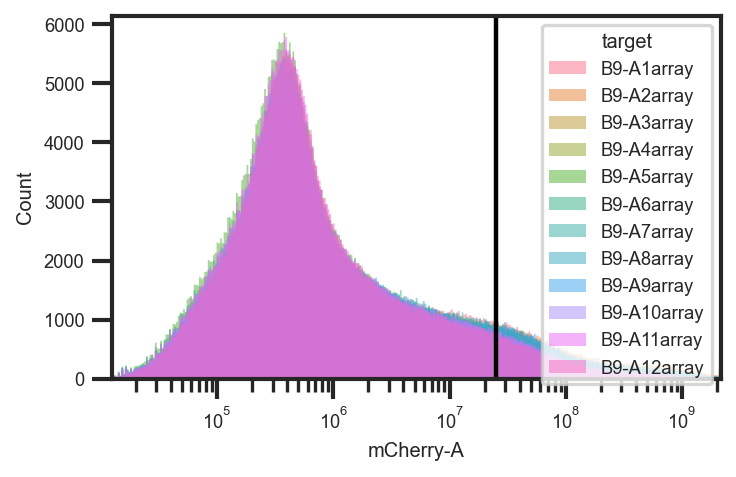

In [8]:
# set a polygon gate for single cells 'P2'
colors = ["#afafaf", "#dba468"]

op_3 = flow.ThresholdOp(name='mCh_pos',
                 channel='mCherry-A',
                 threshold=2.5e7)
ex_3 = op_3.apply(ex_2)

# view gate
op_3.default_view(scale = 'log',
                  huefacet = 'target',
                  subset='(P1 == True)').plot(ex_3, alpha = 0.5, linewidth=0) # , xlim=(0, 0.9e9), ylim=(0, 1.2e9))

# Check that most cells are singlets
P3mCh_pos = len(ex_3.data[(ex_3.data['mCh_pos']==True) & (ex_3.data['P2']==True) & (ex_3.data['P1']==True)])
P3mCh_neg = len(ex_3.data[(ex_3.data['mCh_pos']==False) & (ex_3.data['P2']==True) & (ex_3.data['P1']==True)])
P3_percent = str(round(100*P3mCh_pos/(P3mCh_pos + P3mCh_neg), 1)) + '%'
print('Percent of P1P2 events in P3 gate: %s' % P3_percent)
# plt.savefig(f'TFR003_Citrine_reactivated_memory_mChDistribution.pdf', dpi = 300)

In [9]:
df = ex_2.data
df = df[(df['P2']==True)&(df['P1']==True)]
df.rename(columns={'mCitrine-A': 'Citrine-A', 'mCitrine-H': 'Citrine-H', 'mCitrine-W': 'Citrine-W'}, inplace = True)

/Users/tfuji/Documents/_mypyenvs/cytoflow-env/lib/python3.9/site-packages/pandas/core/frame.py:5039: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [10]:
targetList = sorted(df['target'].unique().tolist())
repList = sorted(df['rep'].unique().tolist())
dayList = sorted(df['day'].unique().tolist())
myorder = [4,3,5,6,7,8,9,10,11,0,1,2]
targetList = [targetList[i] for i in myorder]


In [11]:
targetList

['B9-A2array',
 'B9-A1array',
 'B9-A3array',
 'B9-A4array',
 'B9-A5array',
 'B9-A6array',
 'B9-A7array',
 'B9-A8array',
 'B9-A9array',
 'B9-A10array',
 'B9-A11array',
 'B9-A12array']

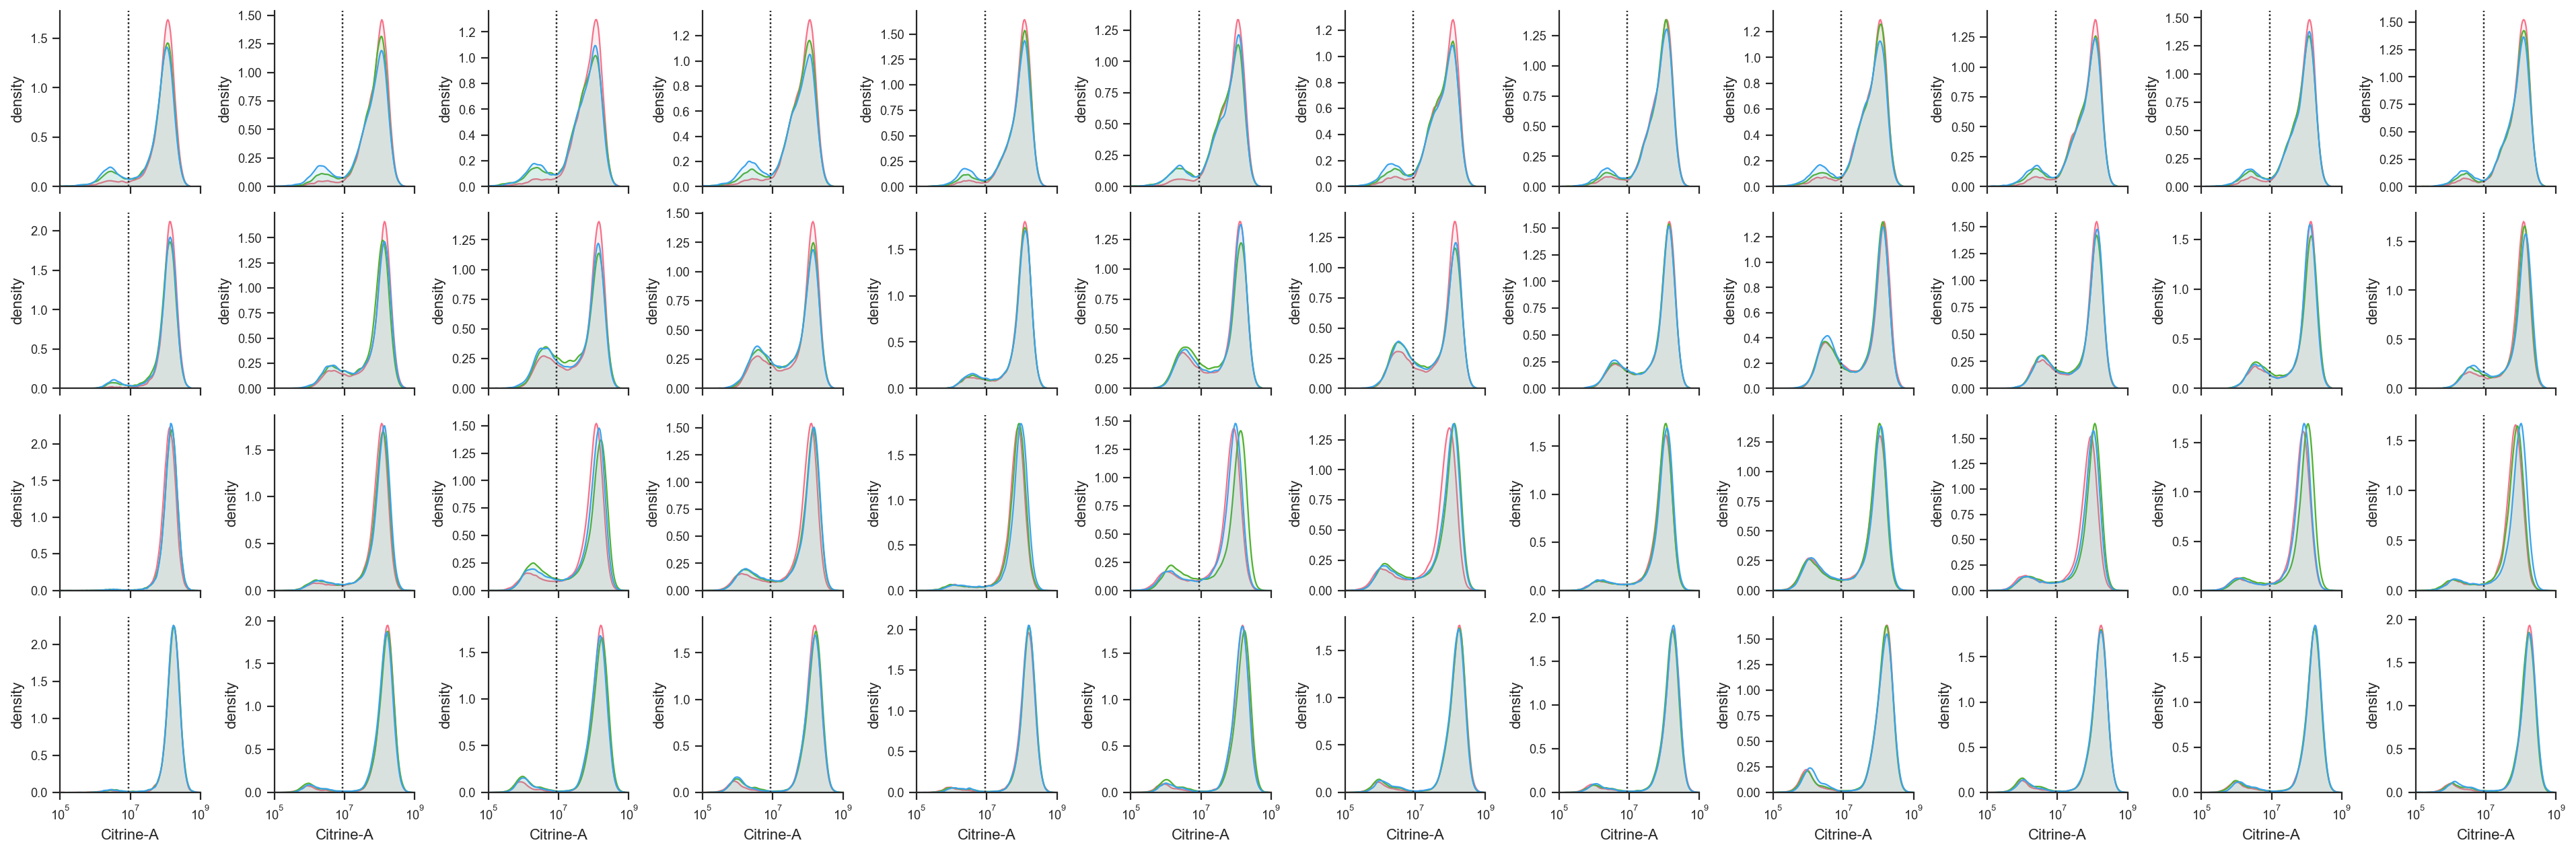

In [ ]:
# plot citrine for a given day
citrine_threshold = 8.8e6
# citrine_threshold = 20.0e6
# Set your custom color palette
colors = ["#bfbfbf","#dba468"]
sns.set_palette(sns.color_palette(colors))

data = df#[(df['day'] == 5)]
# data = df[(df['target'] == 'B9-A1array')]
f = sns.FacetGrid(
    data = data,
    col='target',
    col_order=targetList,
    row='day',
    row_order=dayList,
    hue='rep',
    hue_order=repList,
    sharey = False,
    height = 2,
    aspect = 1,
    margin_titles = False,
)

for ax in f.axes.flat: # zip(f.axes.flat, repList): # # ax, title in zip(f.axes.flat, targetList):
    ax.set_xlabel('Citrine-A', size = 10)
    ax.set_ylabel('density', size = 10)
    ax.set_xlim([1e5, 10e8])
    # ax.set_ylim([0, 0.2])
    ax.tick_params(axis='both',which='both',width=1, length=5)
    ax.spines['bottom'].set_linewidth(1)
    ax.spines['left'].set_linewidth(1)

# f.map(sns.kdeplot, 'Citrine-A', hue='rep', og_scale = True, bw_adjust = 0.6, fill=True, alpha=0.1, linewidth=1)
f.map_dataframe(sns.kdeplot, x='Citrine-A', common_norm=False, multiple='layer',
                log_scale=True, bw_adjust=0.6, fill=True, alpha=0.1, linewidth=1, palette=sns.color_palette(colors))
f.map(plt.axvline, x=citrine_threshold, ls=':', color='#333333', linewidth=1)

f.set_titles('')
# f.set(yticks = [], ylabel = '')
# f.despine(left=True)
plt.tight_layout()
# plt.savefig(f'TFR001assoc_Citrine_timecourse_KRAB.pdf', dpi = 300)

## calculate silenced fraction

In [12]:
citrine_threshold = 8.8e6

sil_fracs = np.empty((len(targetList), len(dayList), len(repList))) * np.nan

for lb, label in enumerate(targetList):
    dataA = df[df['target'] == label]
    for dy, day in enumerate(dayList):
        dataC = dataA[dataA['day'] == day]
        for rp, rep in enumerate(repList):
            data = dataC[dataC['rep'] == rep]
            all = len(data)
            if all > 0:
                citrine_off = len(data[(data["Citrine-A"] < citrine_threshold)])
                sil_fracs[lb, dy, rp] = citrine_off/all

# sil_fracs = np.sqrt(sil_fracs/maxBR)

# subtract silenced fraction of cells in all-safe condition
sil_fracs = sil_fracs/maxBR
sil_fracs_bg = np.mean(sil_fracs[0:1,:,:],axis=2).reshape((1,4,1))
sil_fracs_bg = np.repeat(np.repeat(sil_fracs_bg,12,axis=0),3,axis=2)
sil_fracs = np.sqrt(sil_fracs - sil_fracs_bg)


NameError: name 'maxBR' is not defined

In [ ]:
ZE5rawdatapath = '/Users/tfuji/Library/CloudStorage/GoogleDrive-tfuji@stanford.edu/My Drive/flow_analysis/rawdata_dCas12a/'
with open(ZE5rawdatapath+'ODR013_dCas12aKRAB_OFFfrac.npy', 'wb') as f:
    np.save(f, sil_fracs, allow_pickle=False)

# plot silenced frac

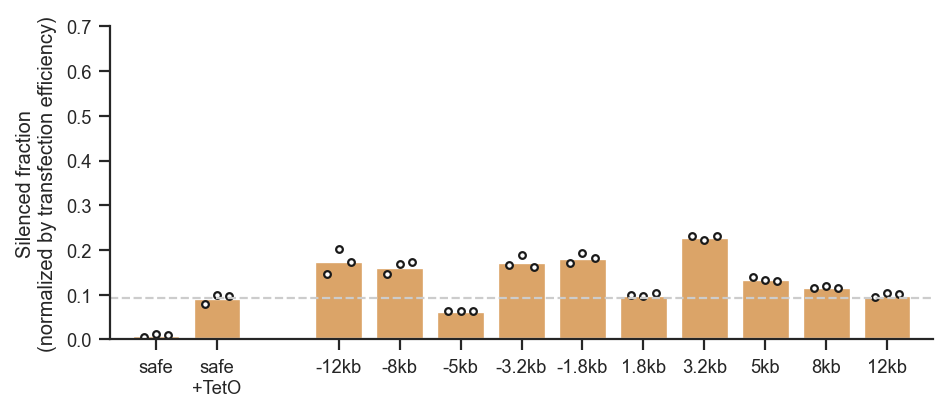

In [14]:
# Create the figure and axis
# fig, ax = plt.subplots(figsize=(3, 3))
colors = "#dba468" # ["#bfbfbf","#dba468","#dba468"]
labels = ['dCas12a']
offset = 0

fig, ax = plt.subplots(figsize=(6, 2.5))
dat = sil_fracs[:,2,:].reshape((12,3))
xtickpos = [0,1,3,4,5,6,7,8,9,10,11,12]
xticklabs = ['safe', 'safe\n+TetO', '-12kb', '-8kb', '-5kb', '-3.2kb', '-1.8kb', '1.8kb', '3.2kb', '5kb', '8kb', '12kb']

# dat = sil_fracs[:,1,:].reshape((12,3))[[0,1,2,3,5,8,10,11],:]
# xtickpos = [0,1,3,4,5,6,7,8]
# xticklabs = ['safe', 'safe\n+TetO', '-12kb', '-8kb', '-3.2kb', '3.2kb', '8kb', '12kb']

means = np.mean(dat, axis=1)
# X positions for the bars
bar_positions = np.arange(len(means)) + offset
bar_positions[2:] = bar_positions[2:]+1

# Plot the bars for the mean values
ax.bar(bar_positions, means, color=colors, width=0.8)

# Plot individual data points
for i in range(dat.shape[0]):
    ax.plot(np.full(dat.shape[1], bar_positions[i])+offset+[-0.2,0,0.2], dat[i, :], 'o', color='white',
            markeredgecolor='k', markeredgewidth=1,markersize=3)
# Add labels and title

plt.xlim(-0.75, 12.75)
plt.ylim(0.0, 0.7)

ax.xaxis.set_tick_params(width=1, length=5)
ax.yaxis.set_tick_params(width=1, length=5)
ax.spines[:].set_linewidth(1)
ax.spines[['top','right']].set_linewidth(0)
ax.axhline(y=means[1],linestyle='--',color=[.8,.8,.8],linewidth=1)
plt.ylabel('Silenced fraction\n(normalized by transfection efficiency)')
# plt.ylabel('√Silenced fraction')
plt.tight_layout()

ax.set_xticks(xtickpos)
ax.set_xticklabels(xticklabs)
# ax.set_ylabel('Values')
# ax.set_title('memory at day 16 after dox removal')

# Show plot
plt.show()
# fig.savefig('dCas12aKRAB_day19_full.pdf', dpi = 300)
# fig.savefig('dCas12aKRAB_day7_full.pdf', dpi = 300)
# fig.savefig('dCas12aKRAB_day5_full.pdf', dpi = 300)
# fig.savefig('dCas12aKRAB_day5_full_noTFeffnorm.pdf', dpi = 300)
# fig.savefig('dCas12aKRAB_day5_omit.pdf', dpi = 300)

In [ ]:
for i in range(dat.shape[0]):
    # print(scipy.stats.ranksums(dat[1,:], dat[i,:]).pvalue)
    print(scipy.stats.ttest_ind(dat[1,:], dat[i,:], equal_var=False).pvalue)

0.00016393628357938005
1.0
0.010213066502896712
0.0033093731894810615
0.4885958407693296
0.002000812091123289
0.0036310346554202432
0.23571413483634818
0.002463103378154732
0.010095747274394624
0.02136196923881521
0.046710404345020856


In [ ]:
np.max(np.std(dat, axis=1))/np.min(np.std(dat, axis=1))

8.687514698682778

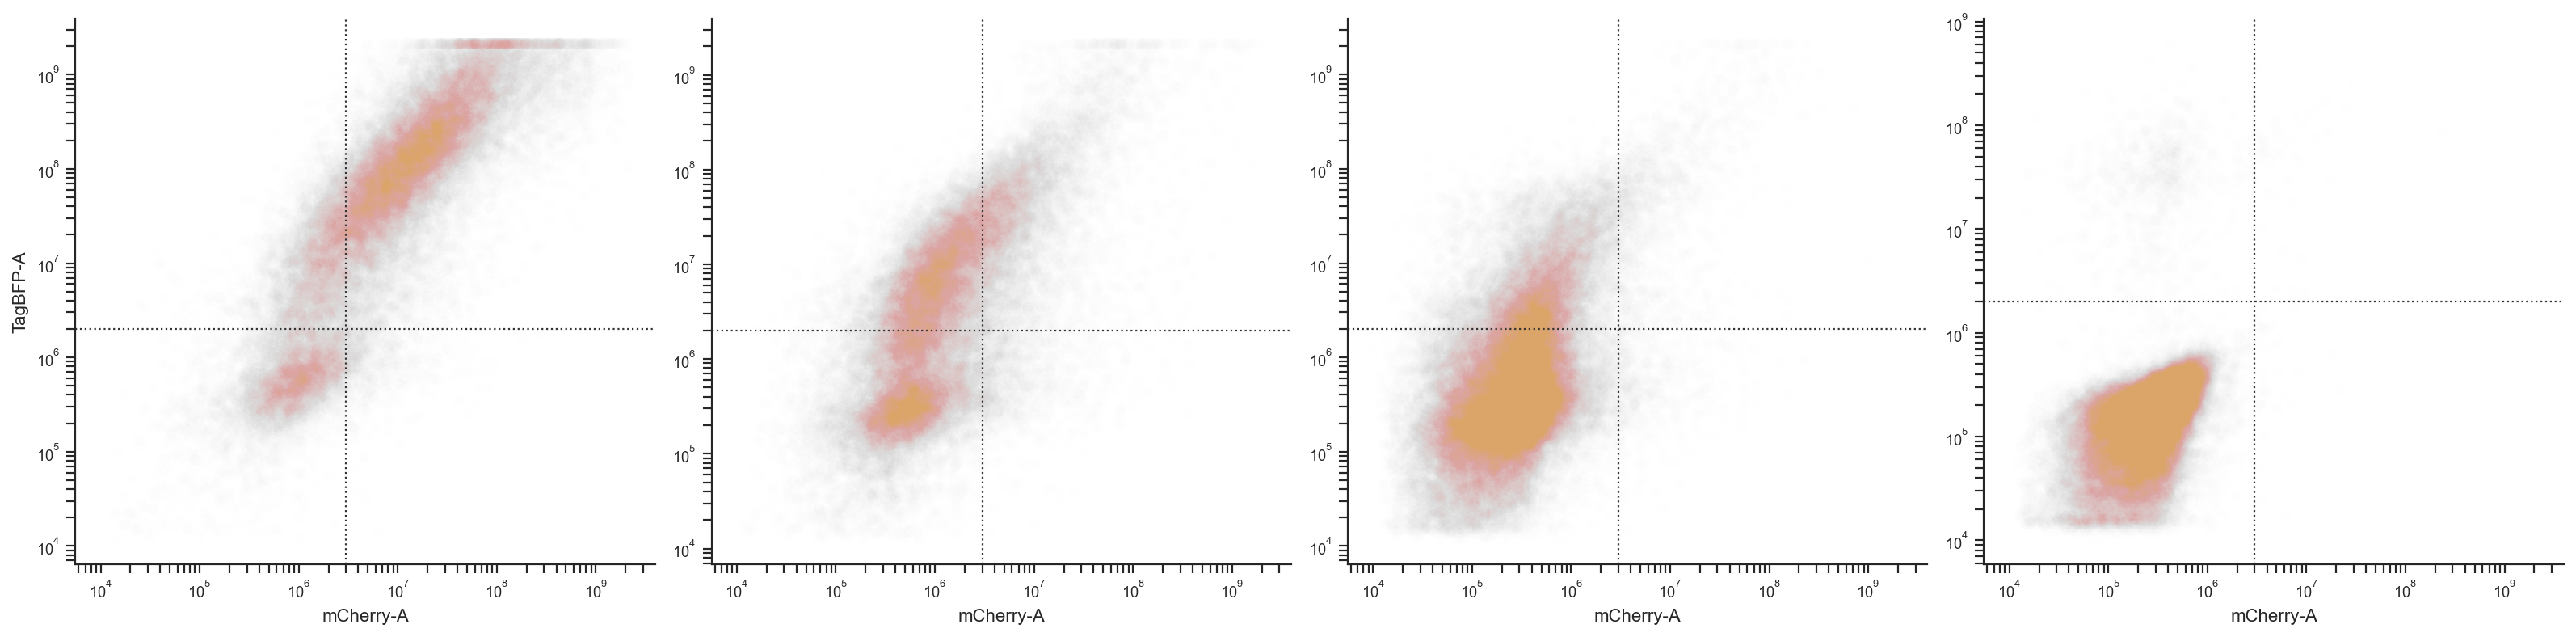

In [ ]:
# plot citrine for a given day
mcherry_threshold = 3.0e6
bfp_threshold = 2.0e6
# Set your custom color palette
colors = ["#dba468"]
sns.set_palette(sns.color_palette(colors))

data = df[(df['target'] == 'B9-A10array') & (df['rep'] == 1)]
f = sns.FacetGrid(
    data = data,
    col='day',
    col_order=dayList,
    # col='target',
    # col_order=['B9-A10array'], # targetList,
    # row='day',
    # row_order=dayList,
    # hue='rep',
    # hue_order=repList,
    sharey = False,
    height = 5,
    aspect = 1,
    margin_titles = False,
)

for ax in f.axes.flat: # zip(f.axes.flat, repList): # # ax, title in zip(f.axes.flat, targetList):
    ax.set_xlabel('mCherry-A', size = 10)
    ax.set_ylabel('TagBFP-A', size = 10)
    # ax.set_xlim([1e5, 10e8])
    # ax.set_ylim([0, 0.2])
    ax.tick_params(axis='both',which='both',width=1, length=5)
    ax.spines['bottom'].set_linewidth(1)
    ax.spines['left'].set_linewidth(1)
    ax.set(xscale="log", yscale="log")

# f.map(sns.kdeplot, 'Citrine-A', hue='rep', og_scale = True, bw_adjust = 0.6, fill=True, alpha=0.1, linewidth=1)
f.map_dataframe(sns.scatterplot, x='mCherry-A', y='TagBFP-A', # common_norm=False, multiple='layer', log_scale=True, bw_adjust=0.6, fill=True,
                 alpha=0.002, palette=sns.color_palette(colors), size=0.1, markers=".")
f.map(plt.axvline, x=mcherry_threshold, ls=':', color='#333333', linewidth=1)
f.map(plt.axhline, y=bfp_threshold, ls=':', color='#333333', linewidth=1)

f.set_titles('')
# f.set(yticks = [], ylabel = '')
# f.despine(left=True)
plt.tight_layout()
# plt.savefig(f'TFR001assoc_Citrine_timecourse_KRAB.pdf', dpi = 300)

In [13]:
BR_fracs = np.empty((len(targetList), len(dayList), len(repList))) * np.nan
mcherry_threshold = 3.0e6
bfp_threshold = 2.0e6

for lb, label in enumerate(targetList):
    dataA = df[df['target'] == label]
    for dy, day in enumerate(dayList):
        dataC = dataA[dataA['day'] == day]
        for rp, rep in enumerate(repList):
            data = dataC[dataC['rep'] == rep]
            all = len(data)
            if all > 0:
                BR_off = len(data[(data["mCherry-A"] > mcherry_threshold) & (data["TagBFP-A"] > bfp_threshold)])
                BR_fracs[lb, dy, rp] = BR_off/all

maxBR = BR_fracs
maxBR[:,1:,:] = maxBR[:,0:1,:]
# maxBR[:,2,:] = maxBR[:,0,:]

In [ ]:
np.mean(BR_fracs,axis=2)

array([[0.75586018, 0.3792825 , 0.00400793],
       [0.72738251, 0.30536318, 0.00325956],
       [0.73511414, 0.36573112, 0.00362465],
       [0.72587019, 0.34899113, 0.00430812],
       [0.53765299, 0.18803267, 0.00207938],
       [0.65363499, 0.25085463, 0.00387025],
       [0.6940499 , 0.29758375, 0.00326485],
       [0.69854426, 0.29079601, 0.0033654 ],
       [0.69843478, 0.29455319, 0.00279252],
       [0.6356348 , 0.24047969, 0.00244337],
       [0.62783369, 0.23067151, 0.00287681],
       [0.60536842, 0.20428898, 0.0027653 ]])

## double normalization

In [15]:
citrine_threshold = 8.8e6

sil_fracs = np.empty((len(targetList), len(dayList), len(repList))) * np.nan

for lb, label in enumerate(targetList):
    dataA = df[df['target'] == label]
    for dy, day in enumerate(dayList):
        dataC = dataA[dataA['day'] == day]
        for rp, rep in enumerate(repList):
            data = dataC[dataC['rep'] == rep]
            all = len(data)
            if all > 0:
                citrine_off = len(data[(data["Citrine-A"] < citrine_threshold)])
                sil_fracs[lb, dy, rp] = citrine_off/all

# sil_fracs = np.sqrt(sil_fracs/maxBR)

# subtract silenced fraction of cells in all-safe condition
sil_fracs = sil_fracs/maxBR
sil_fracs_bg = np.mean(sil_fracs[0:1,:,:],axis=2).reshape((1,4,1))
sil_fracs_bg = np.repeat(np.repeat(sil_fracs_bg,12,axis=0),3,axis=2)
sil_fracs = np.sqrt(sil_fracs - sil_fracs_bg)
sil_fracs = sil_fracs[1:,:,:]
# sil_fracs = sil_fracs[[1,2,3,5,8,10,11],:,:]

/var/folders/w5/3svhrqf506b9999ynf_p7kqm0000gq/T/ipykernel_10376/1231748329.py:22: RuntimeWarning: invalid value encountered in sqrt


In [18]:
dayList

[3, 5, 7, 18]

In [17]:
sil_fracs.shape

(11, 4, 3)

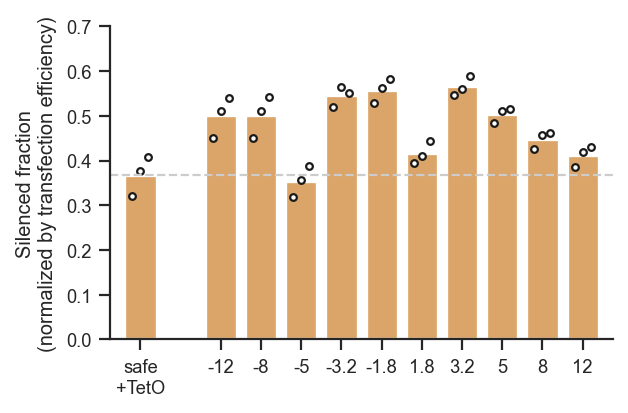

In [21]:
# Create the figure and axis
# fig, ax = plt.subplots(figsize=(3, 3))
colors = "#dba468" # ["#bfbfbf","#dba468","#dba468"]
labels = ['dCas12a']
offset = 0

# fig, ax = plt.subplots(figsize=(3.5, 2.5))
fig, ax = plt.subplots(figsize=(4, 2.5))

# -- omit not working guides -- #
# dat = sil_fracs[:,3,:].reshape((7,3))
# xtickpos = [0,2,3,4,5,6,7]
# xticklabs = ['safe\n+TetO', '-12kb', '-8kb', '-3.2kb', '3.2kb', '8kb', '12kb']

# -- full -- #
dat = sil_fracs[:,1,:].reshape((11,3))
xtickpos = [0,2,3,4,5,6,7,8,9,10,11]
xticklabs = ['safe\n+TetO', '-12kb', '-8kb', '-5kb', '-3.2kb', '-1.8kb', '1.8kb', '3.2kb', '5kb', '8kb', '12kb']
xticklabs = ['safe\n+TetO', '-12', '-8', '-5', '-3.2', '-1.8', '1.8', '3.2', '5', '8', '12']

# dat = sil_fracs[:,1,:].reshape((12,3))[[0,1,2,3,5,8,10,11],:]
# xtickpos = [0,1,3,4,5,6,7,8]
# xticklabs = ['safe', 'safe\n+TetO', '-12kb', '-8kb', '-3.2kb', '3.2kb', '8kb', '12kb']

means = np.mean(dat, axis=1)
# X positions for the bars
bar_positions = np.arange(len(means)) + offset
bar_positions[1:] = bar_positions[1:]+1

# Plot the bars for the mean values
ax.bar(bar_positions, means, color=colors, width=0.8)

# Plot individual data points
for i in range(dat.shape[0]):
    ax.plot(np.full(dat.shape[1], bar_positions[i])+offset+[-0.2,0,0.2], dat[i, :], 'o', color='white',
            markeredgecolor='k', markeredgewidth=1,markersize=3)
# Add labels and title

plt.xlim(-0.75, 7.75)
plt.xlim(-0.75, 11.75)
plt.ylim(0.0, 0.7)

ax.xaxis.set_tick_params(width=1, length=5)
ax.yaxis.set_tick_params(width=1, length=5)
ax.spines[:].set_linewidth(1)
ax.spines[['top','right']].set_linewidth(0)
ax.axhline(y=means[0],linestyle='--',color=[.8,.8,.8],linewidth=1)
plt.ylabel('Silenced fraction\n(normalized by transfection efficiency)')
plt.tight_layout()

ax.set_xticks(xtickpos)
ax.set_xticklabels(xticklabs)
# ax.set_ylabel('Values')
# ax.set_title('memory at day 16 after dox removal')

# Show plot
plt.show()
# fig.savefig('dCas12aKRAB_day19_full.pdf', dpi = 300)
# fig.savefig('dCas12aKRAB_day7_full.pdf', dpi = 300)
# fig.savefig('dCas12aKRAB_day5_full.pdf', dpi = 300)
# fig.savefig('dCas12aKRAB_day5_full_noTFeffnorm.pdf', dpi = 300)
# fig.savefig('dCas12aKRAB_day19_omit_doublenorm.pdf', dpi = 300)
# fig.savefig('dCas12aKRAB_day5_full_doublenorm.pdf', dpi = 300)

In [22]:
dat.shape

(11, 3)

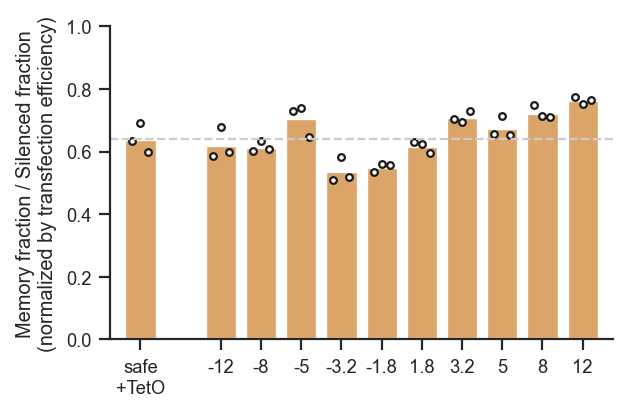

In [25]:
# Create the figure and axis
# fig, ax = plt.subplots(figsize=(3, 3))
colors = "#dba468" # ["#bfbfbf","#dba468","#dba468"]
labels = ['dCas12a']
offset = 0

# fig, ax = plt.subplots(figsize=(3.5, 2.5))
fig, ax = plt.subplots(figsize=(4, 2.5))

# -- omit not working guides -- #
# dat = sil_fracs[:,3,:].reshape((7,3))
# xtickpos = [0,2,3,4,5,6,7]
# xticklabs = ['safe\n+TetO', '-12kb', '-8kb', '-3.2kb', '3.2kb', '8kb', '12kb']

# -- full -- #
dat = sil_fracs[:,3,:].reshape((11,3)) / sil_fracs[:,1,:].reshape((11,3))
xtickpos = [0,2,3,4,5,6,7,8,9,10,11]
xticklabs = ['safe\n+TetO', '-12kb', '-8kb', '-5kb', '-3.2kb', '-1.8kb', '1.8kb', '3.2kb', '5kb', '8kb', '12kb']
xticklabs = ['safe\n+TetO', '-12', '-8', '-5', '-3.2', '-1.8', '1.8', '3.2', '5', '8', '12']

# dat = sil_fracs[:,1,:].reshape((12,3))[[0,1,2,3,5,8,10,11],:]
# xtickpos = [0,1,3,4,5,6,7,8]
# xticklabs = ['safe', 'safe\n+TetO', '-12kb', '-8kb', '-3.2kb', '3.2kb', '8kb', '12kb']

means = np.mean(dat, axis=1)
# X positions for the bars
bar_positions = np.arange(len(means)) + offset
bar_positions[1:] = bar_positions[1:]+1

# Plot the bars for the mean values
ax.bar(bar_positions, means, color=colors, width=0.8)

# Plot individual data points
for i in range(dat.shape[0]):
    ax.plot(np.full(dat.shape[1], bar_positions[i])+offset+[-0.2,0,0.2], dat[i, :], 'o', color='white',
            markeredgecolor='k', markeredgewidth=1,markersize=3)
# Add labels and title

plt.xlim(-0.75, 7.75)
plt.xlim(-0.75, 11.75)
plt.ylim(0.0, 1)

ax.xaxis.set_tick_params(width=1, length=5)
ax.yaxis.set_tick_params(width=1, length=5)
ax.spines[:].set_linewidth(1)
ax.spines[['top','right']].set_linewidth(0)
ax.axhline(y=means[0],linestyle='--',color=[.8,.8,.8],linewidth=1)
plt.ylabel('Memory fraction / Silenced fraction\n(normalized by transfection efficiency)')
plt.tight_layout()

ax.set_xticks(xtickpos)
ax.set_xticklabels(xticklabs)
# ax.set_ylabel('Values')
# ax.set_title('memory at day 16 after dox removal')

# Show plot
plt.show()
fig.savefig('dCas12aKRAB_day19over5_full.pdf', dpi = 300)
# fig.savefig('dCas12aKRAB_day7_full.pdf', dpi = 300)
# fig.savefig('dCas12aKRAB_day5_full.pdf', dpi = 300)
# fig.savefig('dCas12aKRAB_day5_full_noTFeffnorm.pdf', dpi = 300)
# fig.savefig('dCas12aKRAB_day19_omit_doublenorm.pdf', dpi = 300)
# fig.savefig('dCas12aKRAB_day5_full_doublenorm.pdf', dpi = 300)

In [26]:
for i in range(dat.shape[0]):
    # print(scipy.stats.ranksums(dat[1,:], dat[i,:]).pvalue)
    print(scipy.stats.ttest_ind(dat[0,:], dat[i,:], equal_var=False).pvalue)

1.0
0.6376574339965135
0.4335078317537268
0.1842246005083611
0.04490553120873789
0.07021437654593521
0.4911735931298417
0.11697065240727758
0.3946217677045004
0.0779338331141265
0.04040684579269323


In [ ]:
for i in range(dat.shape[0]):
    # print(scipy.stats.ranksums(dat[1,:], dat[i,:]).pvalue)
    print(scipy.stats.ttest_ind(dat[0,:], dat[i,:], equal_var=False).pvalue)

1.0
0.07393940985733102
0.046907074093372914
0.539014272691587
0.08502012501704005
0.03134192452138465
0.33754067053644715
0.0018494515102764543
0.009603030611053135
0.03156316339356286
0.02634270870161306
